In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

## 0. Define file path

In [2]:
path = 'G:\\Data\\Qudi_Data\\2023\\10\\20231024\\AttoDRY2200_Pi3_SPM\\'
filebeginning = '20231024-0910-23_scan31_8mTBnv_FC_3.1_linewidth_scan_full_podmr_autosave_NbSe2_02_A-T17-12_' #here the beginning of the filename, including the date and sample name, is needed
filepath = path + filebeginning

## 0.1 Load data from Qudi 

In [2]:
qafm_data = afm_scanner_logic._qafm_scan_array.copy()
pulsed_data = afm_scanner_logic._pulsed_scan_array.copy()

## 1. Load data from pickle

In [3]:
with open(filepath+'qafm_array_raw.pickle', 'rb') as f:
    qafm_data = pickle.load(f)
with open(filepath+'pulsed_array_raw.pickle', 'rb') as f:
    pulsed_data = pickle.load(f)

## 2. Fit full scan with chosen fit (expensive-ish)

In [3]:
pulsed_data['pulsed_fw']['data'].shape

(2, 25, 100)

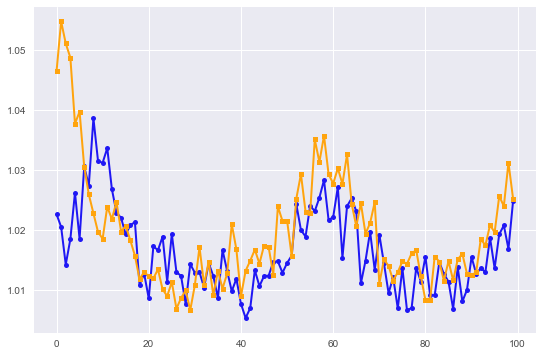

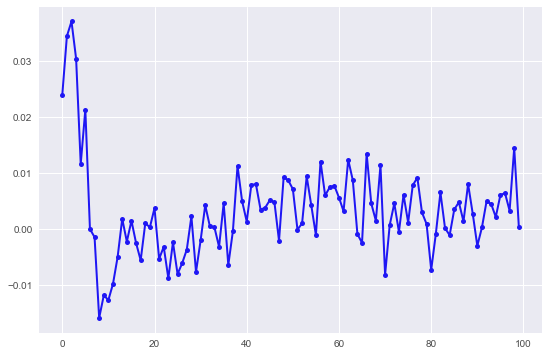

In [4]:
d = pulsed_data['pulsed_fw']['data'][0,0]
d_alt = pulsed_data['pulsed_fw']['data_alternating'][0,0]
plt.plot(d)
plt.plot(d_alt)
plt.show()
plt.plot(-d+d_alt)
plt.show()

In [7]:
pulsed_data['pulsed_fw'].keys()

dict_keys(['data', 'data_alternating', 'data_std', 'data_alternating_std', 'data_fit', 'data_alternating_fit', 'data_delta', 'data_raw', 'coord0_arr', 'coord1_arr', 'coord2_arr', 'measured_units', 'scale_fac', 'si_units', 'nice_name', 'params', 'display_range'])

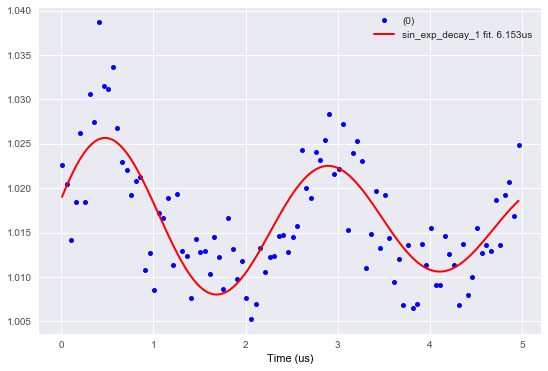

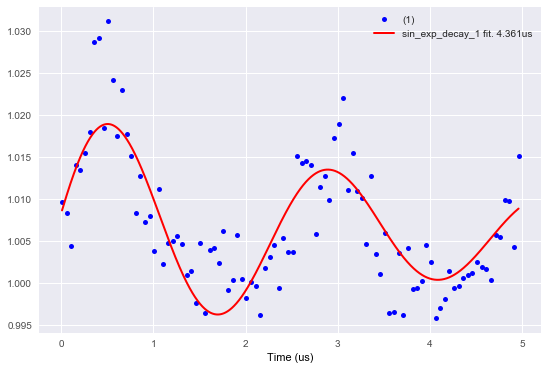

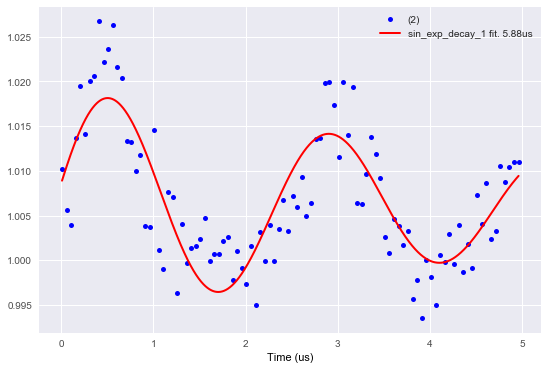

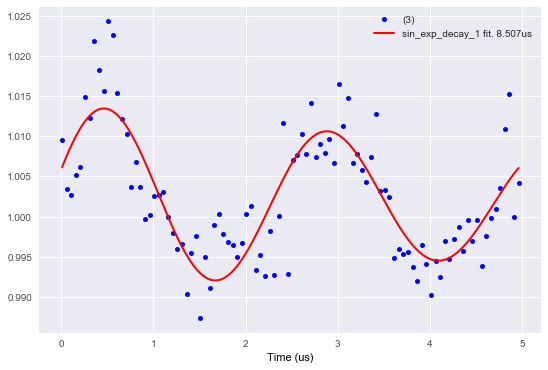

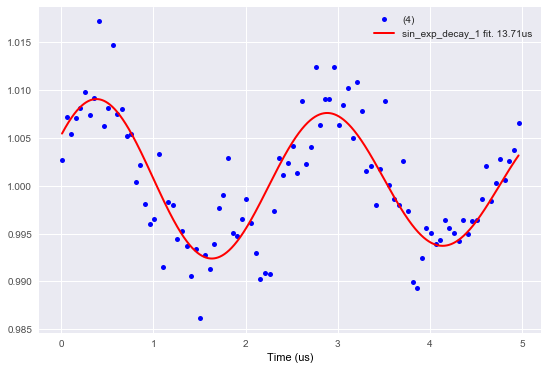

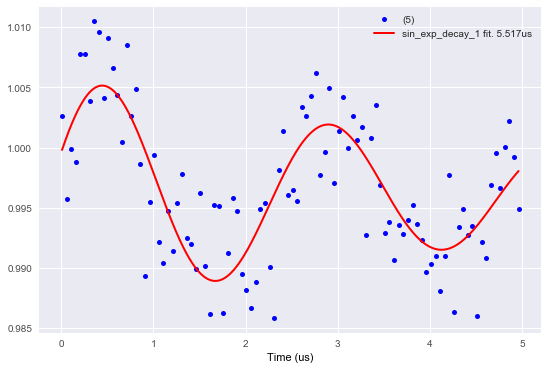

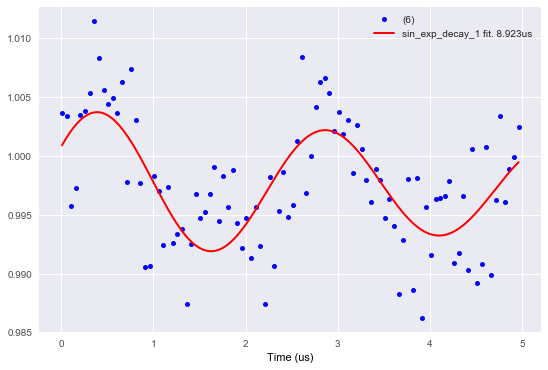

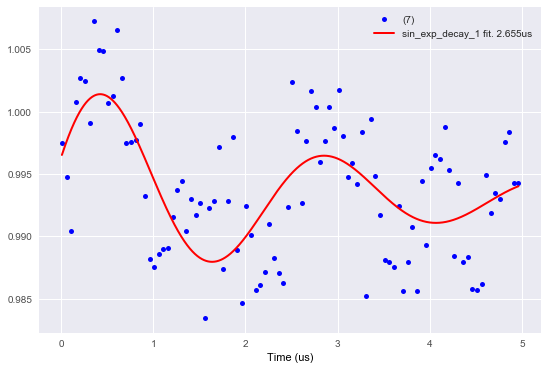

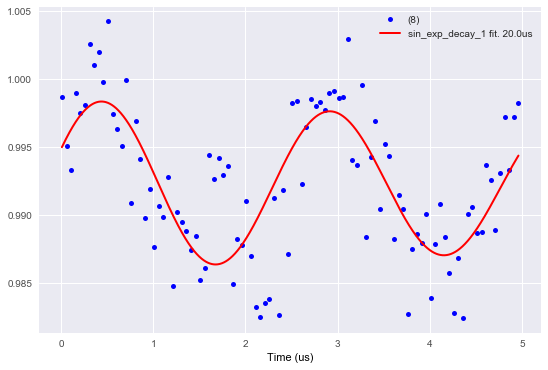

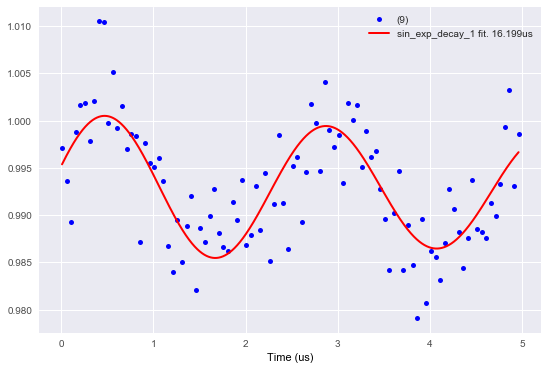

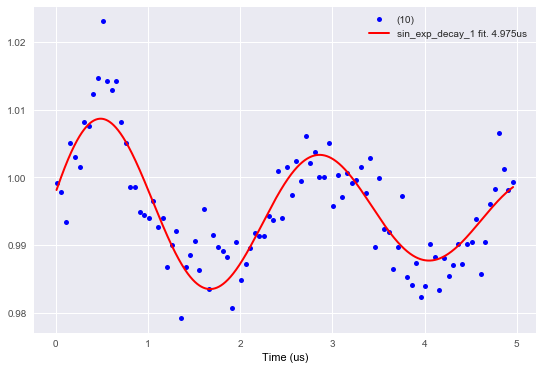

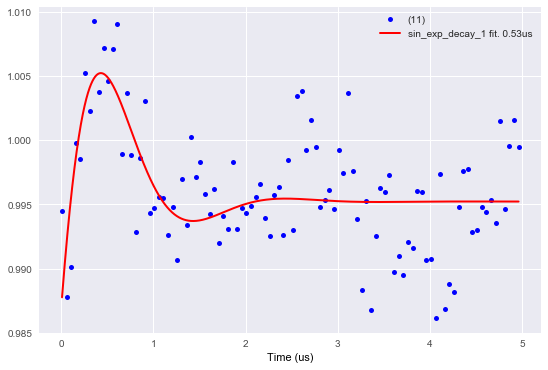

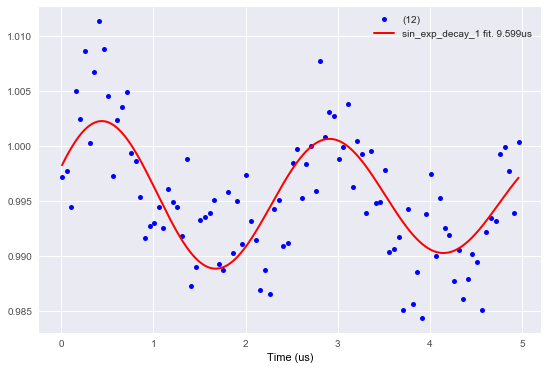

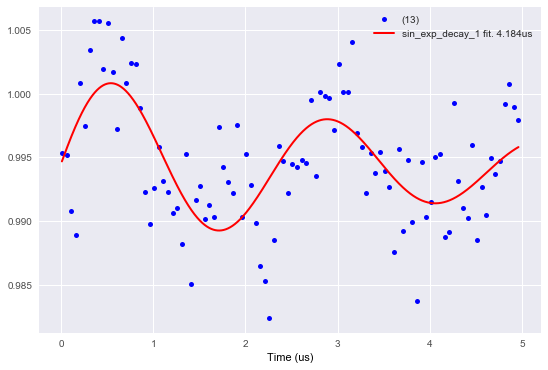

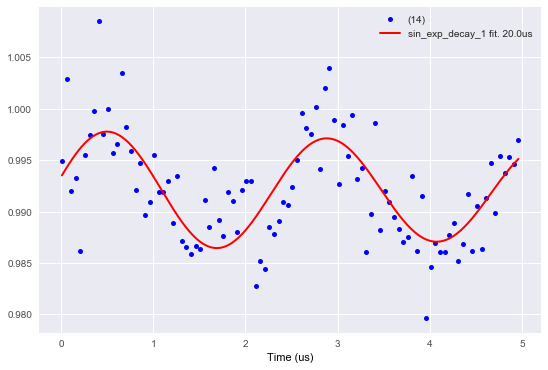

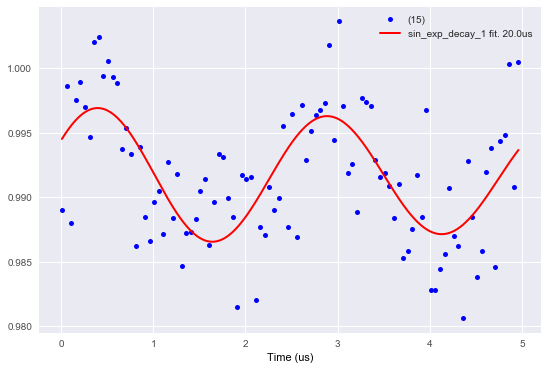

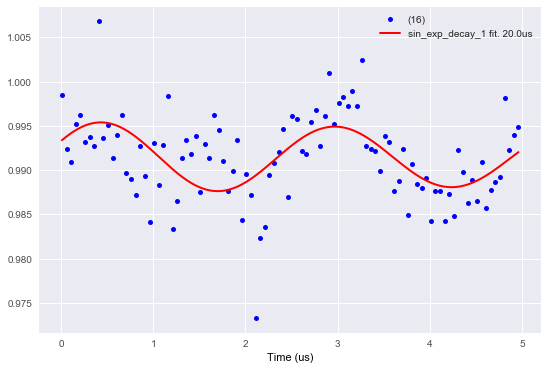

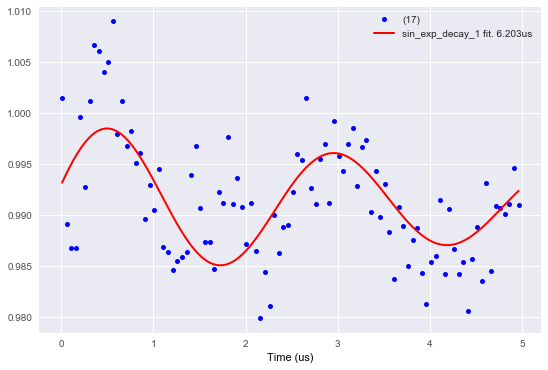

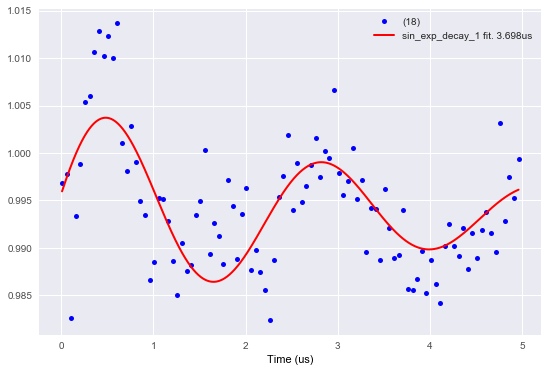

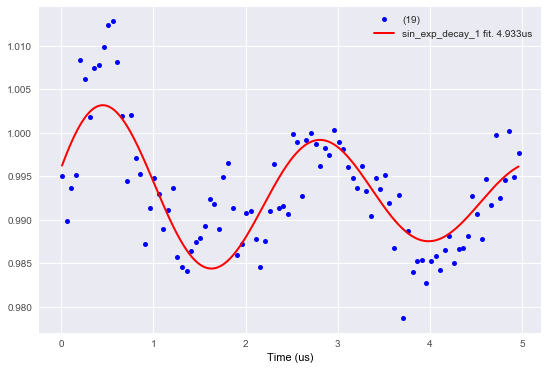

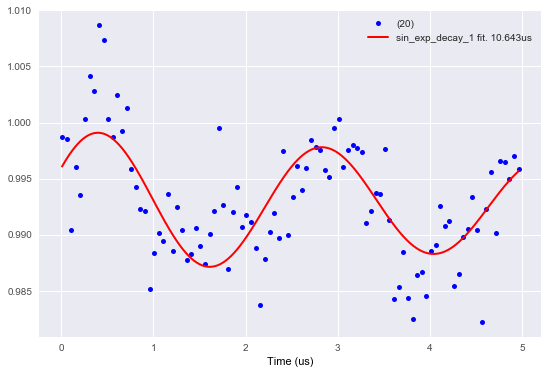

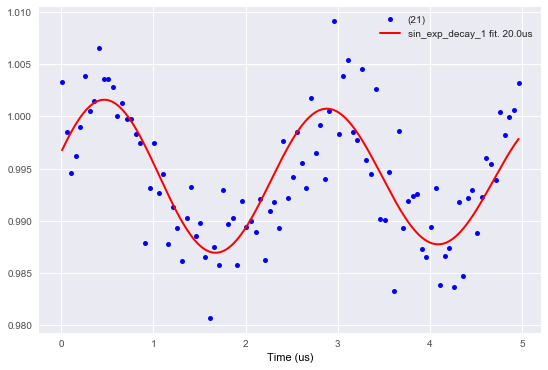

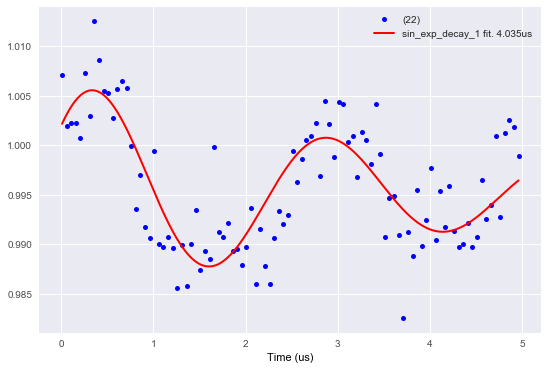

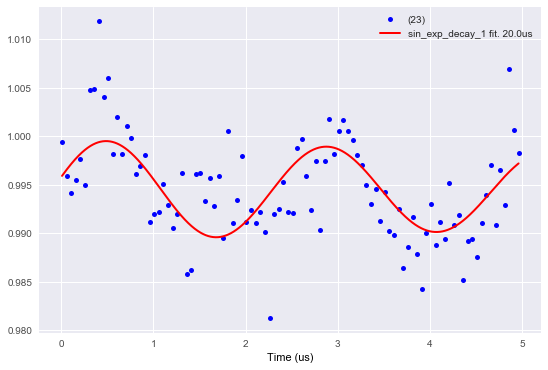

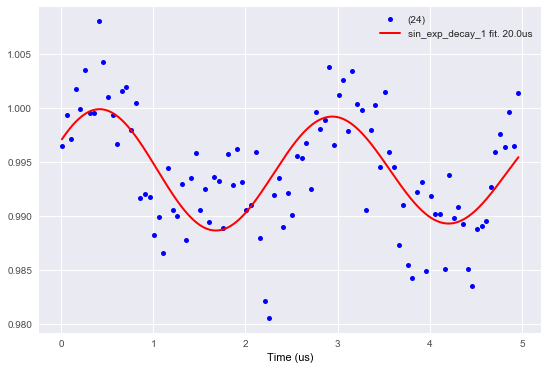

In [24]:
#Analyse scan with PODMR
#Gathering data from dictonary

N = 0 #LINE NUM
alternating = True

data = pulsed_data['pulsed_fw']['data'][N,:]
if alternating:
    data_alt = pulsed_data['pulsed_fw']['data_alternating'][N,:]
var_list = pulsed_data['pulsed_fw']['coord2_arr']
coord0_num = qafm_data['Height(Dac)_fw']['params']['coord0_num (#)']
coord1_num = qafm_data['Height(Dac)_fw']['params']['coord1_num (#)']
fit_param0 = np.zeros(data.shape[0])
fit_param1 = np.zeros(data.shape[0])
fit_param2 = np.zeros(data.shape[0])

#Define the measured peak properties
mode = 'sin_exp_decay_1'

for i in range(coord0_num):
        #Determine fit
        try:
            if mode == 'exp_decay_alternating':
                fit_data = -data_alt[i] +data[i] 
                fit = afm_scanner_logic._fitlogic.make_decayexponential_fit(var_list,fit_data,estimator=afm_scanner_logic._fitlogic.estimate_decayexponential)
                lm,_ = fitlogic.make_decayexponential_model()
                fit_param0[i] = fit.params['lifetime'].value
            elif mode == 'sin_exp_decay_alternating':
                fit_data = -data_alt[i] +data[i] 
                fit = afm_scanner_logic._fitlogic.make_sineexponentialdecay_fit(var_list,fit_data,estimator=afm_scanner_logic._fitlogic.estimate_sineexponentialdecay)
                lm,_ = fitlogic.make_sineexponentialdecay_model()
                fit_param0[i] = fit.params['lifetime'].value
            elif mode == 'sin_exp_decay_0':
                fit_data = data_alt[i]
                fit = afm_scanner_logic._fitlogic.make_sineexponentialdecay_fit(var_list,fit_data,estimator=afm_scanner_logic._fitlogic.estimate_sineexponentialdecay)
                lm,_ = fitlogic.make_sineexponentialdecay_model()
                fit_param0[i] = fit.params['lifetime'].value
            elif mode == 'sin_exp_decay_1':
                fit_data = data[i] 
                fit = afm_scanner_logic._fitlogic.make_sineexponentialdecay_fit(var_list,fit_data,estimator=afm_scanner_logic._fitlogic.estimate_sineexponentialdecay)
                lm,_ = fitlogic.make_sineexponentialdecay_model()
                fit_param0[i] = fit.params['lifetime'].value
                
            else:
                pass
        except:
            pass
       # EXPESNIVE
        plt.plot(var_list*1e6,fit_data,'bo',label=f'({i})')
        x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)*1e6
        plt.plot(x, lm.eval(fit.params, x=x/1e6),'r-', label=f'{mode} fit. {round(fit_param0[i]*1e6,3)}us')
        plt.xlabel("Time (us)")
        plt.legend()
        plt.show()

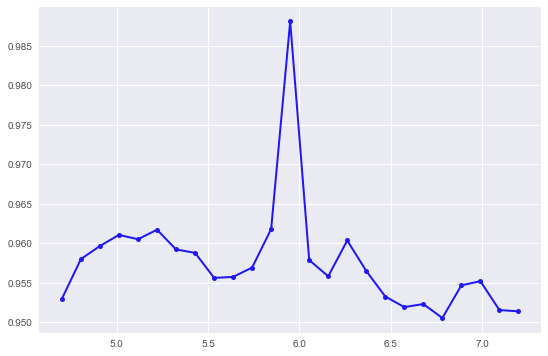

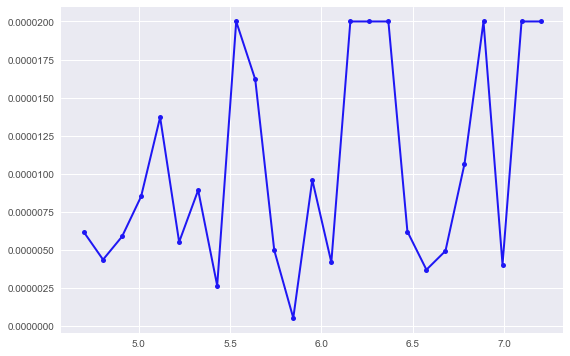

In [25]:
x_gwy = qafm_data['Height(Dac)_fw']['coord0_arr']
x = x_gwy*10**6
topo = qafm_data['Height(Dac)_fw']['data']*10**6

plt.plot(x,topo[0])
plt.show()

plt.plot(x,fit_param0)
plt.show()

# # plt.plot(x,fwhm[0])
# plt.errorbar(x=x, y=fwhm[0],
#                  yerr=fwhm_err[0], fmt='-o', color='blue',
#                  capsize=2, capthick=0.9,
#                  elinewidth=1.2)
# plt.axhline(y = fwhm_bias, color = 'r', linestyle = '--') 
# plt.show()

In [9]:
topography = topo[0].copy()
field = (b_field[0]-b_field_bias).copy()
linewidth = fwhm[0].copy()
linewidth_err = fwhm_err[0].copy()
x_um = (x_gwy*10**6).copy()

### Fitting the linewidth data

center 6.262212449268095
fwhm (nm) 20.253164751117545
fwhm err (nm) 32.88971530083266


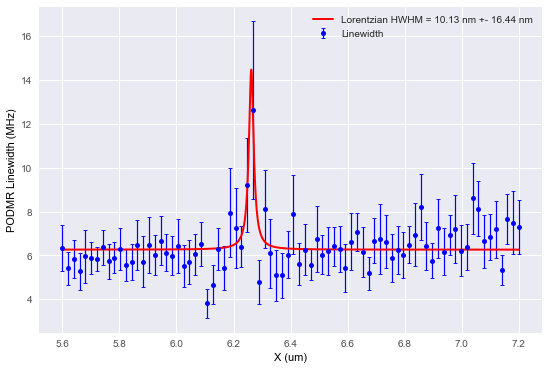

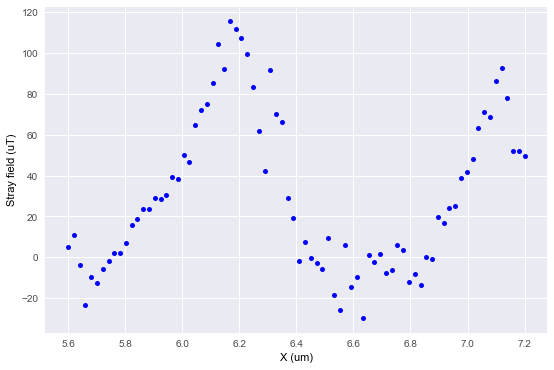

In [32]:
fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(x_um,linewidth,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_peak)
lm,_ = fitlogic.make_lorentzian_model()
print('center',fit.params['center'].value)
print('fwhm (nm)',fit.params['fwhm'].value*1e3) #FWHM in MHz#
print('fwhm err (nm)', fit.params['fwhm'].stderr*1e3) #FWHM in MHz

hwhm = round(fit.params["fwhm"].value*1e3/2,2)
hwhm_err = round(fit.params["fwhm"].stderr*1e3/2,2)

# plt.plot(x_um,linewidth,'bo',label=f'Linewidth')
plt.errorbar(x=x_um, y=linewidth,
                 yerr=linewidth_err, fmt='o', color='blue',
                 capsize=2, capthick=0.9,
                 elinewidth=1.2,label=f'Linewidth')


x = np.linspace(x_um[0],x_um[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-', label = f'Lorentzian HWHM = {hwhm} nm +- {hwhm_err} nm')

plt.xlabel('X (um)')
plt.ylabel('PODMR Linewidth (MHz)')

plt.legend()
plt.rcParams['figure.figsize'] = (9, 6)
fontsize = 12
# with open(filepath+f'_jupyter_plot_linewidth.png', 'wb') as f:
#     plt.savefig(f,format='png',dpi=400)
plt.show()

plt.plot(x_um,field*1e6,'bo')

plt.xlabel('X (um)')
plt.ylabel('Stray field (uT)')

plt.legend()
plt.rcParams['figure.figsize'] = (9, 6)
fontsize = 12
with open(filepath+f'_jupyter_plot_field.png', 'wb') as f:
    plt.savefig(f,format='png',dpi=400)
plt.show()